In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models_org as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

## Load up the Bed Profile

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

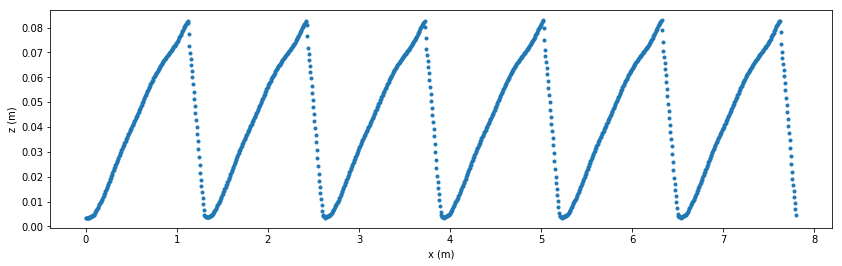

In [2]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

# Model Runs for Paper

- Equilibrium vs non-Equlibrium
- Shallow water vs simple flow model
- modified Ycr (+20%, -20%)
- other models (Euler, Upwinding, MacCormick)

In [3]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.0010
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 20 cm Case Non-Equilibrium

2020-01-26 16:48:26,065 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:49:02,086 INFO CLAW: Solution 1 computed for time t=300.000000
0.23701594940081439
0.42807568713511196


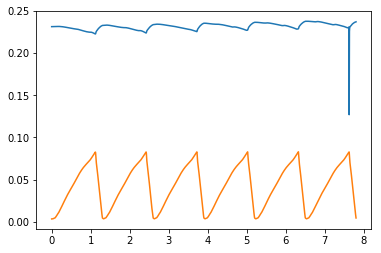

<Figure size 1008x432 with 0 Axes>

In [4]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=2000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
2020-01-26 16:49:02,341 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:49:52,696 INFO CLAW: Solution 1 computed for time t=241.965501
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 0.0004966389741324336
2020-01-26 16:49:52,796 INFO CLAW: Solution 0 computed for time t=0.000000


/pymorph/models/shallow_water_solver.py:66: RuntimeWarning: invalid value encountered in log
  cf = ((1./kappa)*np.log(0.368*q[0,:]/ks) + Bs)


2020-01-26 16:49:53,352 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:49:56,504 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:49:58,173 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:49:58,272 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:49:59,927 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:50:00,162 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:50:01,824 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:50:01,923 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:50:03,577 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:50:03,836 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:50:05,483 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:50:05,583 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 16:50:07,244 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 16:50:0

Text(0, 0.5, 'z (m)')

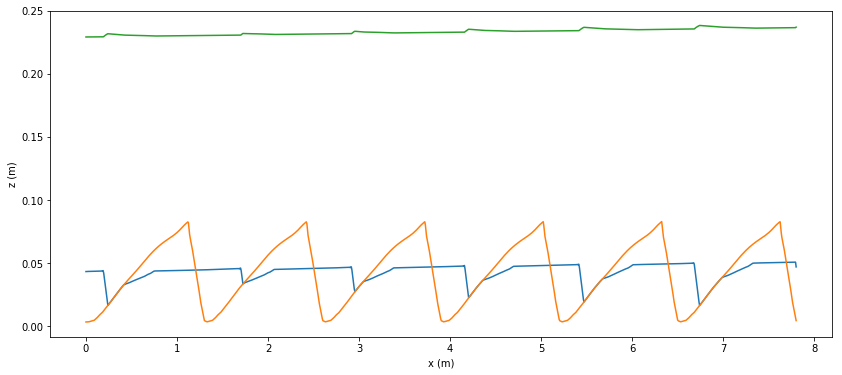

In [5]:


run_name = 'Section_5.2_dune_5_q_{0}_h_{1}_D50_{2}'.format('20cm','237mm',D50)

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [15]:

run_name = 'Section_5.2_dune_5_q_{0}_h_{1}_D50_{2}'.format('20cm','237mm',D50)

verts = np.load('_output/{0}_verts.npy'.format(run_name))
verts[0,:,0]

array([0.00000000e+00, 6.50542118e-03, 1.30108424e-02, ...,
       7.78698916e+00, 7.79349458e+00, 7.80000000e+00])

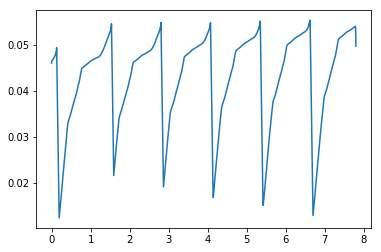

## 32 cm Flow Case 

2020-01-26 20:42:54,993 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 20:43:58,975 INFO CLAW: Solution 1 computed for time t=300.000000
0.356994186134206
0.5921206651245402


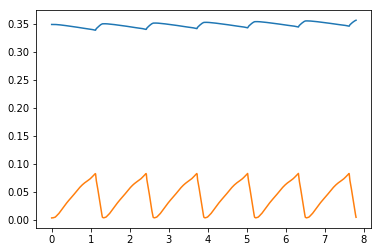

<Figure size 1008x432 with 0 Axes>

In [6]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
2020-01-26 20:43:59,292 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 20:44:51,262 INFO CLAW: Solution 1 computed for time t=244.240914
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 9.058558802246077e-06
2020-01-26 20:44:51,364 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 20:44:53,476 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 20:44:53,929 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 20:44:56,052 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 20:44:56,153 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 20:44:58,274 INFO CLAW: Solution 1 computed for time t=10.000000
2020-01-26 20:44:58,469 INFO CLAW: Solution 0 computed for time t=0.000000
2020-01-26 20:45:00,587 INFO CLAW: 

Text(0, 0.5, 'z (m)')

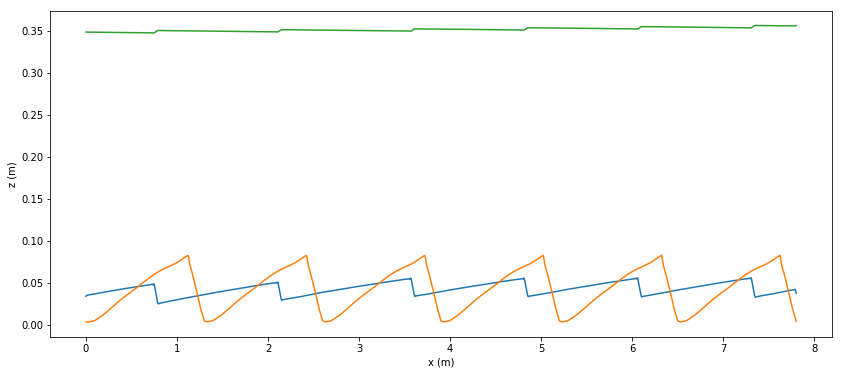

In [7]:
run_name = 'Section_5.2_dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm',D50)

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

Text(0.5, 0, 'Time (mins)')

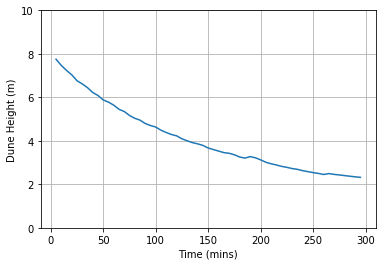

In [8]:
import utils.post_processing as post
verts = np.load('_output/{0}_verts.npy'.format(run_name))

extractionTimeMins = 5.
heights = [post.calculate_wave_height(verts[t,:,1],dx)*100. for t in range((verts.shape[0]))]
times = np.array([(t*extractionTimeMins + 5.0) for t in range((verts.shape[0]))])


#df = pd.read_csv('a3down_dune_heigth.txt',sep='\t')

plt.plot(times,heights)

#plt.plot(df['t'],df['dune'], 'o')

plt.ylim([0,10])
plt.grid()
plt.ylabel('Dune Height (m)')
plt.xlabel('Time (mins)')